In [1]:
import enum
import math
import numpy as np
import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = torch.from_numpy(arr).to(device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == 'sqrt':
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: 1-np.sqrt(t + 0.0001),
        )
    elif schedule_name == "trunc_cos":
        return betas_for_alpha_bar2(
            num_diffusion_timesteps,
            lambda t: np.cos((t + 0.1) / 1.1 * np.pi / 2) ** 2,
        )
    elif schedule_name == 'trunc_lin':
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001 + 0.01
        beta_end = scale * 0.02 + 0.01
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == 'pw_lin':
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001 + 0.01
        beta_mid = scale * 0.0001  #scale * 0.02
        beta_end = scale * 0.02
        first_part = np.linspace(
            beta_start, beta_mid, 10, dtype=np.float64
        )
        second_part = np.linspace(
            beta_mid, beta_end, num_diffusion_timesteps - 10 , dtype=np.float64
        )
        return np.concatenate(
            [first_part, second_part]
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

def betas_for_alpha_bar2(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    betas.append(min(1-alpha_bar(0), max_beta))
    for i in range(num_diffusion_timesteps-1):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

class GaussianDiffusion:
    """
    Utilities for training and sampling diffusion models.

    Ported directly from here, and then adapted over time to further experimentation.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L42

    :param betas: a 1-D numpy array of betas for each diffusion timestep,
                  starting at T and going to 1.
    """

    def __init__(
        self,
        betas
    ):
        # Use float64 for accuracy.
        betas = np.array(betas, dtype=np.float64)
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas
        self.alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain.
        self.posterior_log_variance_clipped = np.log(
            np.append(self.posterior_variance[1], self.posterior_variance[1:])
        )
        self.posterior_mean_coef1 = (
            betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * np.sqrt(alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).

        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = (
            _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        )
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = _extract_into_tensor(
            self.log_one_minus_alphas_cumprod, t, x_start.shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.

        In other words, sample from q(x_t | x_0).

        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        assert x_start.shape == x_t.shape
        posterior_mean = (
            _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        assert (
            posterior_mean.shape[0]
            == posterior_variance.shape[0]
            == posterior_log_variance_clipped.shape[0]
            == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped


In [2]:
import pandas as pd
k = pd.read_csv("wikipedia/wikipedia/wikipedia.tsv",sep='\t')
import numpy as np
from IPython.display import clear_output
import torch
from tqdm.notebook import tqdm
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from functools import partial
from inspect import isfunction

# **Pre-processing**

In [3]:
k.describe()

,row_id,user_id,item_id,timestamp
count,157474.000000,157474.000000,157474.000000,1.574740e+05
mean,78736.500000,2068.397729,474.453548,1.351086e+06
std,45458.972483,2037.260841,292.442417,7.325805e+05
min,0.000000,0.000000,0.000000,0.000000e+00
25%,39368.250000,425.000000,210.000000,7.276182e+05
50%,78736.500000,1257.000000,466.000000,1.361150e+06
75%,118104.750000,3204.000000,731.000000,1.976077e+06
max,157473.000000,8226.000000,999.000000,2.678373e+06


In [4]:
print(k)

        row_id  user_id  item_id  timestamp
0            0        0        0        0.0
1            1        1        1       36.0
2            2        1        1       77.0
3            3        2        2      131.0
4            4        1        1      150.0
...        ...      ...      ...        ...
157469  157469     2003      632  2678155.0
157470  157470     3762      798  2678158.0
157471  157471     2399      495  2678293.0
157472  157472     7479      920  2678333.0
157473  157473     2399      495  2678373.0

[157474 rows x 4 columns]


In [5]:
k['timestamp'] = (k['timestamp'] - k['timestamp'].min()) / (k['timestamp'].max() - k['timestamp'].min()) * (100 - 0) + 0

In [6]:
print(k)

        row_id  user_id  item_id   timestamp
0            0        0        0    0.000000
1            1        1        1    0.001344
2            2        1        1    0.002875
3            3        2        2    0.004891
4            4        1        1    0.005600
...        ...      ...      ...         ...
157469  157469     2003      632   99.991861
157470  157470     3762      798   99.991973
157471  157471     2399      495   99.997013
157472  157472     7479      920   99.998507
157473  157473     2399      495  100.000000

[157474 rows x 4 columns]


In [7]:
print(k['user_id'].nunique())

8227


In [8]:
seq_length=20
target_length=10

In [9]:
class WikipediaDataset(Dataset):
    def __init__(self, data, seq_length, target_length):
        self.data = data
        self.seq_length = seq_length
        self.target_length = target_length
    def __len__(self):
        return len(self.data)-(self.seq_length + self.target_length)
    def __getitem__(self, idx):
        seq_start_idx = idx
        seq_end_idx = idx + self.seq_length
        target_start_idx = seq_end_idx
        target_end_idx = seq_end_idx + self.target_length
        seq_data = self.data.iloc[seq_start_idx:seq_end_idx]
        target_data = self.data.iloc[target_start_idx:target_end_idx]
        seq_user_ids = torch.tensor(seq_data['user_id'].values)
        seq_timestamps = torch.tensor(seq_data['timestamp'].values)
        target_user_ids = torch.tensor(target_data['user_id'].values)
        target_timestamps = torch.tensor(target_data['timestamp'].values)

        return seq_user_ids, seq_timestamps, target_user_ids, target_timestamps
data = k[['user_id', 'timestamp']]
dataset = WikipediaDataset(data, seq_length, target_length)

batch_size = 32


In [10]:
dataset.__len__()

157444

In [11]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = train_test_split(dataset, test_size=0.)
Data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
for batch in Data_loader:
    seq_user_ids, seq_timestamps, target_user_ids, target_timestamps = batch
    break

In [16]:
print(seq_user_ids.shape, seq_timestamps, target_user_ids.shape, target_timestamps)

torch.Size([32, 20]) tensor([[0.0000, 0.0013, 0.0029, 0.0049, 0.0056, 0.0057, 0.0063, 0.0081, 0.0081,
         0.0090, 0.0110, 0.0112, 0.0140, 0.0142, 0.0143, 0.0143, 0.0144, 0.0147,
         0.0150, 0.0150],
        [0.0013, 0.0029, 0.0049, 0.0056, 0.0057, 0.0063, 0.0081, 0.0081, 0.0090,
         0.0110, 0.0112, 0.0140, 0.0142, 0.0143, 0.0143, 0.0144, 0.0147, 0.0150,
         0.0150, 0.0161],
        [0.0029, 0.0049, 0.0056, 0.0057, 0.0063, 0.0081, 0.0081, 0.0090, 0.0110,
         0.0112, 0.0140, 0.0142, 0.0143, 0.0143, 0.0144, 0.0147, 0.0150, 0.0150,
         0.0161, 0.0170],
        [0.0049, 0.0056, 0.0057, 0.0063, 0.0081, 0.0081, 0.0090, 0.0110, 0.0112,
         0.0140, 0.0142, 0.0143, 0.0143, 0.0144, 0.0147, 0.0150, 0.0150, 0.0161,
         0.0170, 0.0174],
        [0.0056, 0.0057, 0.0063, 0.0081, 0.0081, 0.0090, 0.0110, 0.0112, 0.0140,
         0.0142, 0.0143, 0.0143, 0.0144, 0.0147, 0.0150, 0.0150, 0.0161, 0.0170,
         0.0174, 0.0210],
        [0.0057, 0.0063, 0.0081, 0.0081

In [17]:
np.random.seed(0)

# **Architecture**

In [18]:
def dirac_delta(target_times):
    times = torch.diff(target_times, dim = 1)
    times = torch.cat((target_times[:,:1,:],times),dim = 1)
    times[times == 0] = 1e-8 
    times = torch.log(times)
    return times
def recover_times(times):
    if times.shape[1] == 1:
        return times.squeeze(1) 
    times = torch.exp(times)
    times[times == 0] = 1e-8  # Replace zeros with a small value
    target_times = torch.cumsum(times, dim=1)
    return target_times

In [19]:
class HistoryEncoder(nn.Module):
    def __init__(self, n_marks, emb_dim, diff_var_size):
        super(HistoryEncoder, self).__init__()
        self.embedding = nn.Embedding(n_marks, emb_dim) # here prob embed class
        self.t_weights = nn.Parameter(torch.randn(emb_dim))
        self.t_bias = nn.Parameter(torch.randn(emb_dim))
        self.gru = nn.GRU(2 * emb_dim ,diff_var_size, num_layers = 1, batch_first = True)
    def forward(self, seq_marks, seq_time):
        e_mark = self.embedding(seq_marks)
        e_time = torch.cos(seq_time.unsqueeze(2) * self.t_weights.unsqueeze(0).unsqueeze(1) + self.t_bias.unsqueeze(0).unsqueeze(1))   
        concat = torch.cat([e_mark, e_time], dim = 2)
        _, history_emb = self.gru(concat.float())
        return history_emb 

In [20]:
encoder = HistoryEncoder(8227, 32, 33)
print(encoder)

HistoryEncoder(
  (embedding): Embedding(8227, 32)
  (gru): GRU(64, 33, batch_first=True)
)


In [21]:
def target_embedding(target_marks, target_times, encoder):
    target_e_mark = encoder.embedding(target_marks)
    target_times = target_times.unsqueeze(2)
    transform_time = dirac_delta(target_times.float())
    diff_var_0 = torch.cat([transform_time,target_e_mark], dim = 2)
    return diff_var_0

In [22]:
def create_positional_encoding(dimension, max_len=30):
    pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dimension, 2, dtype=torch.float) * (-math.log(10000.0) / dimension))
    pe = torch.zeros(max_len, dimension)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    return pe
def get_positional_encoding(pos, dimension, batch_size, max_len=30): 
    pe = create_positional_encoding(dimension, max_len)
    return pe[pos].unsqueeze(0).repeat(batch_size,1,1).to(device)

In [23]:
class Residual_block(nn.Module):
    def __init__(self, trig_enc_size, hidden_size, diff_var_size, seq_feature_size, dilation = 2):
        super(Residual_block, self).__init__()
        self.step_embeddings = nn.Sequential(
                       nn.Linear(trig_enc_size,hidden_size),
                       nn.SiLU(),
                       nn.Linear(hidden_size,diff_var_size)
        )
        self.dil_conv = nn.Conv2d(1, hidden_size, kernel_size = 3, padding = dilation, dilation = dilation)
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size = 1)
        self.conv2 = nn.Conv2d(hidden_size, 1, kernel_size = 1)
    def forward(self, diff_var, seq_feature, trig_pos_size, batch_size, target_length):
        v_n = self.step_embeddings(get_positional_encoding(torch.arange(0,target_length), trig_pos_size, batch_size, max_len=30))
        x = diff_var + v_n
        x = x.unsqueeze(1)
        x = self.dil_conv(x)
        seq_feature = seq_feature.unsqueeze(1)
        y = self.conv1(seq_feature)
        y = y + x
        y = torch.sigmoid(y) * torch.tanh(y)
        y = self.conv2(y)
        y = y.squeeze(1)
        return y + diff_var, y

In [24]:
class DenoisingDecoder(nn.Module):
    def __init__(self, diff_var_size, hidden_size, residual_layers):
        super(DenoisingDecoder,self).__init__()
        self.gru = nn.GRU(diff_var_size, diff_var_size, batch_first = True)
        self.residual_layers = nn.ModuleList(
                    [
                        Residual_block(diff_var_size - 1, hidden_size, diff_var_size, diff_var_size - 1)
                        for i in range(residual_layers)
                    ])   
        self.mlp1 = nn.Sequential(
                    nn.Linear(diff_var_size * residual_layers, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, diff_var_size)
        )
        self.mlp2 = nn.Sequential(
                    nn.Linear(diff_var_size*3, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size,hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size,diff_var_size)
        )
    def forward(self, diff_var_n, history_embed, trig_pos_size, batch_size, target_length):
        seq_feature, _ = self.gru(diff_var_n, history_embed)
        outputs = []
        diff_var = diff_var_n
        for layer in self.residual_layers:
            skip_connection, out = layer(diff_var, seq_feature, trig_pos_size, batch_size, target_length)
            diff_var = skip_connection
            outputs.append(out)  
        outputs = torch.cat(outputs, dim=2)
        context_feature = self.mlp1(outputs) 
        concat = torch.cat((context_feature, seq_feature, diff_var_n), dim = 2)   
        predicted = self.mlp2(concat)
        return predicted      

In [25]:
class Emb_inv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Emb_inv, self).__init__()
        self.model = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.GELU(),
                nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=2)
        return x

In [26]:
#Example forward
#Initialization
encoder = HistoryEncoder(n_marks = 8225, emb_dim = 32, diff_var_size = 33).to(device)
decoder = DenoisingDecoder(diff_var_size = 33, hidden_size = 32, residual_layers = 2).to(device)
emb_inv = Emb_inv(32, 64, 8225).to(device)
noise = GaussianDiffusion(get_named_beta_schedule("linear",num_diffusion_timesteps = 500))

# Forward pass (train)
history_embed = encoder.forward(seq_user_ids.to(device), seq_timestamps.to(device))
diff_var_0 = target_embedding(target_user_ids.to(device), target_timestamps.to(device), encoder)
diff_var_n = noise.q_sample(diff_var_0,499)
diff_var_0_hat = decoder.forward(diff_var_n, history_embed, 32, 32, target_length)
x_time_hat, x_mark_hat = diff_var_0_hat[..., :1], diff_var_0_hat[..., 1:]
out = emb_inv(x_mark_hat)
out.shape

torch.Size([32, 10, 8225])

In [32]:
def multi_step_mae(actual_values, predicted_values): # 32*10 (batch_size*pred_seq_length)
    total_steps = 0
    absolute_errors = []
    for true_steps, predicted_steps in zip(actual_values, predicted_values):
        for true_value, predicted_value in zip(true_steps, predicted_steps):
            total_steps += 1
            absolute_error = abs(true_value - predicted_value)
            absolute_errors.append(absolute_error)
    mae = sum(absolute_errors) / total_steps
    return mae, sum(absolute_errors), total_steps

In [33]:
def multi_step_accuracy(y_true, y_pred):
    total_steps = 0
    correct_predictions = 0
    for true_steps, predicted_steps in zip(y_true, y_pred):
        for true_mark, predicted_mark in zip(true_steps, predicted_steps):
            total_steps += 1
            if true_mark == torch.argmax(predicted_mark):
                correct_predictions += 1
    accuracy = correct_predictions / total_steps
    return accuracy, correct_predictions, total_steps

In [34]:
encoder = HistoryEncoder(n_marks = 8225, emb_dim = 32, diff_var_size = 33).to(device)
decoder = DenoisingDecoder(diff_var_size = 33, hidden_size = 32, residual_layers = 2).to(device)
emb_inv = Emb_inv(32, 64, 8225).to(device)
params1 = list(encoder.parameters())
params2 = list(decoder.parameters())
params3 = list(emb_inv.parameters())
opt = optim.Adam([{"params": params1, "lr":1e-3, "weight_decay":1e-3}, 
                 {"params": params2,"lr":1e-3, "weight_decay":1e-3},
                {"params": params3, "lr":1e-3, "weight_decay":1e-3}])
L2 = nn.CrossEntropyLoss()

In [35]:
def loss_fn(diff_var_0, diff_var_0_hat, mark, pred_mark, n,noise):
    if(n>1):
        L1 = torch.norm(diff_var_0 - diff_var_0_hat)**2
    elif(n==1):
        L1 = torch.norm(diff_var_0_hat[..., 1:] - encoder.embedding(mark))**2
    loss = L1 + torch.norm((noise.sqrt_alphas_cumprod[-1] * diff_var_0))**2 + L2(pred_mark.view(320,8225), mark.view(-1)) 
    return loss

In [36]:
def evaluation(test_loader, batch_size, noise_std=0.1):
    encoder.eval()
    decoder.eval()
    emb_inv.eval()
    correct_pred_mark = 0
    total_pred_mark = 0 
    total_absolute_error = 0
    total_pred_time = 0
    noise = GaussianDiffusion(get_named_beta_schedule("linear",num_diffusion_timesteps = 500))
    with torch.no_grad():
        for batch in test_loader:
                a,b,c,d = batch
                seq_user_ids, seq_timestamps, target_user_ids, target_timestamps = a.to(device),b.to(device),c.to(device),d.to(device)
               # giving complete random noise
               # empty_tensor = (torch.empty(32,10,33)+(torch.ones(32,10,33) * 1e-8)).to(device)
               # diff_var_n = noise.q_sample(empty_tensor, 499)
                diff_var_0 = target_embedding(target_user_ids, target_timestamps, encoder)
                #diff_var_n = diff_var_0 + torch.randn_like(diff_var_0).to(device)
                diff_var_n = noise.q_sample(diff_var_0, 499)
                # forward pass
                history_embed = encoder(seq_user_ids, seq_timestamps)
                diff_var_0_hat = decoder(diff_var_n, history_embed, 32, 32, target_length)
                x_time_hat, x_mark_hat = diff_var_0_hat[..., :1], diff_var_0_hat[..., 1:]
                pred_mark, pred_time = emb_inv(x_mark_hat), recover_times(x_time_hat)
                # loss calculation
                #loss = loss_fn(diff_var_0, diff_var_0_hat, target_user_ids, pred_mark, n,noise)
                #loss_arr.append(loss.cpu().detach()/batch_size)    
                mae_batch, ae_batch, total_time_steps = multi_step_mae(target_timestamps.cpu(), pred_time.detach().cpu())
                acc_batch, correct, total_mark_steps = multi_step_accuracy(target_user_ids, pred_mark)
                correct_pred_mark += correct
                total_pred_mark += total_mark_steps
                total_absolute_error += ae_batch.item()
                total_pred_time += total_time_steps
    #print("MAE for entire testset = ", (total_absolute_error/total_pred_time))
    #print("ACC for entire testset = ", (correct_pred_mark/total_pred_mark)*100)
    return (total_absolute_error/total_pred_time),(correct_pred_mark/total_pred_mark)*100

In [39]:
train_loss_arr  = []
train_acc_arr = []
train_mae_arr = []
def train(epochs, opt, loss_fn, batch_size, loss_arr, acc_arr, mae_arr, N = 500):
    encoder.train()
    decoder.train()
    emb_inv.train()
    noise = GaussianDiffusion(get_named_beta_schedule("linear",num_diffusion_timesteps = N))
    loss_arr = np.zeros(epochs+1)
    val = 0
    for epoch in tqdm(range(epochs), total = epochs, unit = "epoch"):
        for batch in Data_loader:
            a,b,c,d = batch
            seq_user_ids, seq_timestamps, target_user_ids, target_timestamps = a.to(device),b.to(device),c.to(device),d.to(device)   
            # get embedding for targets
            diff_var_0 = target_embedding(target_user_ids, target_timestamps, encoder)
            # add noise to embedding
            n = np.random.randint(1, N)  
            diff_var_n = noise.q_sample(diff_var_0,n)
            # forward pass
            history_embed = encoder(seq_user_ids, seq_timestamps)
            diff_var_0_hat = decoder(diff_var_n, history_embed, 32, 32, target_length)
            # get predicted values from predicted embedding 
            x_time_hat, x_mark_hat = diff_var_0_hat[..., :1], diff_var_0_hat[..., 1:]
            pred_mark, pred_time = emb_inv(x_mark_hat), recover_times(x_time_hat)
            # loss calculation
            opt.zero_grad()
            loss = loss_fn(diff_var_0, diff_var_0_hat, target_user_ids, pred_mark, n,noise)
            loss.backward()
            opt.step()
            loss_arr[epoch+1] = (loss_arr[epoch]*epoch + loss.cpu().detach()/batch_size) /(epoch+1)
            mae, ae_sum, total_steps = multi_step_mae(target_timestamps.cpu().numpy(), pred_time.detach().cpu().numpy())
            acc, correct, total_steps = multi_step_accuracy(target_user_ids, pred_mark)
            acc_arr.append(acc)
            mae_arr.append(mae)
        mae, acc = evaluation(Dataloader,32)
        if(acc > val):
            val = acc
            torch.save(encoder.state_dict(),'encoder.pth')
            torch.save(decoder.state_dict(),'decoder.pth')
            torch.save(emb_inv.state_dict(),'emb_inv.pth')
        encoder.train()
        decoder.train()
        emb_inv.train()
        clear_output(wait=True)
        plt.figure()
        plt.plot(loss_arr[1:epoch],'-*')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()


In [40]:
train(50, opt, loss_fn, 32, train_loss_arr, train_acc_arr, train_mae_arr, 500)


  0%|          | 0/50 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

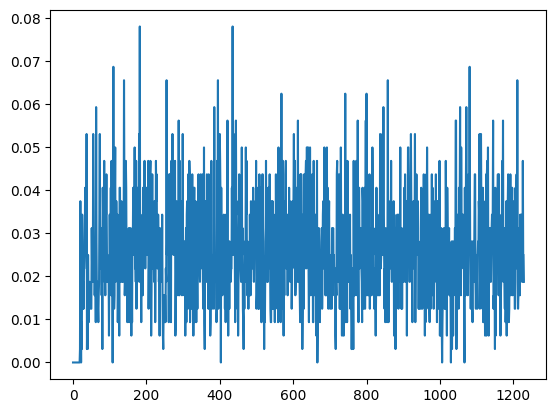

In [46]:
plt.plot(train_acc_arr)
plt.show()

In [4]:
import pickle
import pandas as pd
with open("Stackoverflow/whole_manifold_format.pkl", "rb") as file:
    data = pickle.load(file)

In [5]:
df = pd.DataFrame(data)

In [6]:
df

,timestamps,types,lengths,timeintervals,event_type_num
0,"[1130723.4030001163, 3949193.957000017, 510543...","[0, 1, 2, 3, 4, 3, 2, 5, 6, 7, 7, 7, 8, 9, 0, ...",48,"[1130723.4030001163, 2818470.553999901, 115623...",22
1,"[307295.84699988365, 2698551.230000019, 313534...","[3, 8, 0, 8, 0, 8, 3, 7, 3, 3, 3, 3, 3, 3, 11,...",55,"[307295.84699988365, 2391255.3830001354, 43679...",22
2,"[1638764.4070000648, 3744059.0099999905, 37443...","[5, 5, 13, 1, 3, 1, 15, 2, 0, 5, 3, 8, 1, 4, 3...",69,"[1638764.4070000648, 2105294.6029999256, 303.6...",22
3,"[2426830.6530001163, 2552002.387000084, 321923...","[2, 6, 3, 0, 14, 5, 8, 4, 5, 7, 17, 7, 6, 18, ...",64,"[2426830.6530001163, 125171.73399996758, 66722...",22
4,"[858126.4430000782, 2281907.342999935, 2625637...","[6, 0, 3, 6, 0, 8, 6, 3, 9, 5, 3, 4, 6, 5, 8, ...",59,"[858126.4430000782, 1423780.899999857, 343730....",22
...,...,...,...,...,...
6628,"[28305819.50300002, 28325616.78699994, 3097065...","[0, 6, 0, 0, 0, 5, 13, 1, 0, 0, 3, 0, 5, 1, 0,...",56,"[28305819.50300002, 19797.28399991989, 2645034...",22
6629,"[30797510.579999924, 30798109.069999933, 30939...","[5, 13, 5, 13, 5, 5, 5, 13, 5, 5, 1, 5, 5, 5, ...",58,"[30797510.579999924, 598.4900000095367, 141022...",22
6630,"[34885483.687000036, 36779506.29699993, 375324...","[10, 7, 17, 0, 5, 5, 1, 5, 1, 5, 13, 3, 5, 1, ...",46,"[34885483.687000036, 1894022.609999895, 752939...",22
6631,"[35039461.28699994, 35321101.81999993, 3548262...","[0, 6, 3, 7, 17, 0, 9, 0, 0, 18, 3, 0, 0, 0, 6...",50,"[35039461.28699994, 281640.53299999237, 161521...",22
